# load libraries

In [1]:
from b_sam import Bayes_SAM
import torch
import numpy as np
import torch.nn as nn
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
%config InlineBackend.figure_format='retina'
colorlist = [ '#435571', '#FFFFFF','#8F5F3F', ]
mycmap = LinearSegmentedColormap.from_list('mycmap', colorlist, N=256) 

# set hyperparameters

In [2]:

batchsize = 30
learningrate = 0.5
beta1 = 0.9 
beta2 = 0.999
rho = 0.05
gamma = 0.1 
epochs = 250
wdecay = 0.0001
num_epoch = 250
m_sharpness = 5

# create toy dataset

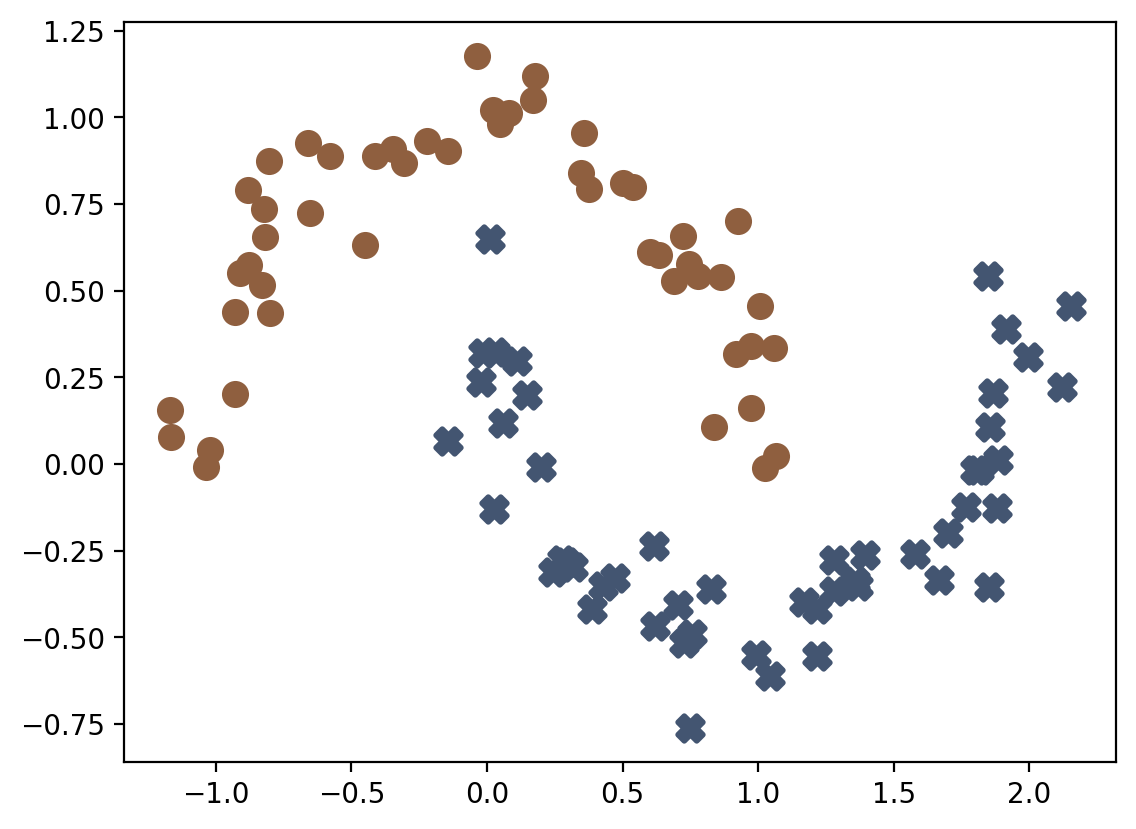

In [3]:
 
N = 100
np.random.seed(1)
X, y = make_moons(N, noise=0.1)

plt.scatter(X[y==0,0], X[y==0, 1], c=colorlist[-1], marker='o', edgecolors=colorlist[-1], s=60, linewidth=2)
plt.scatter(X[y==1,0], X[y==1, 1], c=colorlist[0], marker='X', edgecolors=colorlist[0], s=80, linewidth=2)

y = y.reshape(-1,1)
torch.set_default_dtype(torch.float32)
class TwoMoons(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.X = torch.from_numpy(x_data).float()
        self.Y = torch.from_numpy(y_data).float()

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

two_moons = TwoMoons(X, y)
train_data_loader = torch.utils.data.DataLoader(two_moons, batch_size = 30)

# set up model and optimizer

In [4]:
# define model and loss func
net = torch.nn.Sequential(nn.Linear(2, 32),
                            nn.ELU(),
                            nn.Linear(32, 32),
                            nn.ELU(),
                            nn.Linear(32, 32),
                            nn.ELU(),
                            nn.Linear(32, 1)
                            )

loss_func = nn.BCEWithLogitsLoss()

# define optimizer
bsam = Bayes_SAM(net.parameters(), Ndata = N, beta1 = beta1, beta2 = beta2, lr = learningrate, rho = rho, gamma = gamma, wdecay = wdecay)

# train model

In [5]:
for epoch in range(num_epoch):
    
    # calculate lr decay factor
    t = float(epoch) / float(num_epoch)
    lr_decay_factor = 0.5 * (1.0 + np.cos(np.pi * t))
    
    cur_epoch_loss = []
    
    for (batch_X, batch_y) in train_data_loader:

        batch_X_split = torch.split(batch_X, int(batch_X.size(0) / m_sharpness))
        batch_y_split = torch.split(batch_y, int(batch_X.size(0) / m_sharpness))
        
        bsam.reset_gradient_state()
        for k in range(m_sharpness):
        
            # clean stored gradient
            bsam.zero_grad()
            # move from w to (w+e)
            bsam.add_noise()
            # calcualte ∇L(w+e) and calculate running average of g_noise
            loss_func(net(batch_X_split[k]), batch_y_split[k]).backward()
            bsam.update_g_noise(k)
            
            # move from w to (w+ϵ), cur gradient is ∇L(w+e) so we use it
            bsam.add_perturbation()
            # clean stored gradient
            bsam.zero_grad()
            # calcualte ∇L(w+ϵ) and calculate running average of g_perturb
            loss_func(net(batch_X_split[k]), batch_y_split[k]).backward()
            bsam.update_g_perturb(k)
        
        # update mean parameter
        cur_lr = learningrate * lr_decay_factor
        bsam.step(cur_lr)
        
        # log loss
        with torch.no_grad():
            pred = net(batch_X)
            loss = loss_func(pred, batch_y)
            cur_epoch_loss.append(loss)
    
    if epoch % 10 == 0:
        print(epoch, np.mean(cur_epoch_loss))

0 0.7107252
10 0.2789055
20 0.27149194
30 0.2676425
40 0.26413348
50 0.2593917
60 0.2535418
70 0.24584249
80 0.23480691
90 0.21751621
100 0.1708579
110 0.08387671
120 0.04122994
130 0.02874431
140 0.014713062
150 0.013575783
160 0.007241736
170 0.0068634124
180 0.008753836
190 0.004439052
200 0.0047355783
210 0.0046231383
220 0.004899532
230 0.004087877
240 0.003982632


# plot trained results

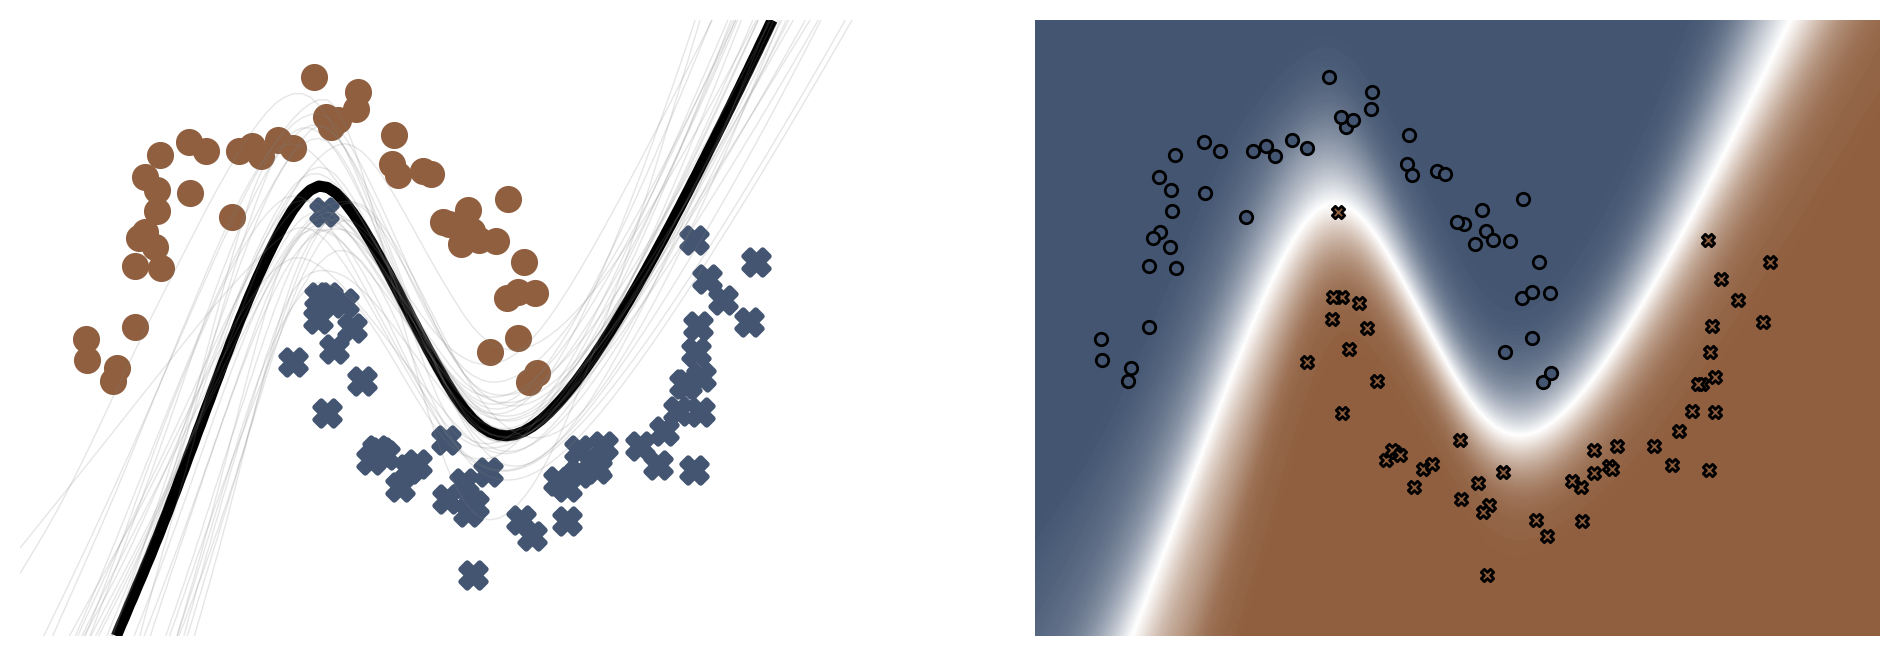

In [6]:
Nsample = 30

# plot data set
colors = np.array([[1,0,0], [0,0,1]])

Nplot = 100
xaxis = np.linspace(-1.5, 2.7, Nplot)
yaxis = np.linspace(-1.0, 1.4, Nplot)
xx, yy = np.meshgrid(xaxis, yaxis)
Xtest = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) 

mean_pred_logits = net(torch.from_numpy(Xtest).float())
mean_pred = 1 / (1 + torch.exp(-mean_pred_logits))

posterior_predictive_mean = []

for i in range(Nsample):
    bsam.reset_param()
    bsam.add_noise()
    
    sample_pred_logits = net(torch.from_numpy(Xtest).float())
    sample_pred = 1 / (1 + torch.exp(-sample_pred_logits))
    posterior_predictive_mean.append(sample_pred.detach().numpy())

y = y.reshape(-1)

fig = plt.figure(figsize = (12,4))
# plot mean and sampled deciison boundary
ax = fig.add_subplot(121)
ax.set_xlim([-1.5, 2.7])
ax.set_ylim([-1.0, 1.4])
ax.contour(xaxis, yaxis, mean_pred.detach().numpy().reshape(Nplot, Nplot), [0.5], colors='black', linewidths=4)
ax.scatter(X[y==0,0], X[y==0, 1], c=colorlist[-1], marker='o', edgecolors=colorlist[-1], s=60, linewidth=2)
ax.scatter(X[y==1,0], X[y==1, 1], c=colorlist[0], marker='X', edgecolors=colorlist[0], s=80, linewidth=2)
ax.set_axis_off()  

for i in range(Nsample):
    bsam.reset_param()
    bsam.add_noise()
    
    sample_pred_logits = net(torch.from_numpy(Xtest).float())
    sample_pred = 1 / (1 + torch.exp(-sample_pred_logits))
    posterior_predictive_mean.append(sample_pred.detach().numpy())
    if torch.min(sample_pred) < 0.5 and torch.max(sample_pred) > 0.5:
        ax.contour(xaxis, yaxis, sample_pred.detach().numpy().reshape(Nplot, Nplot), [0.5], colors='gray', alpha=0.2, linewidths=0.5)
        

# plot posterior predictive mean 
ax = fig.add_subplot(122)
ax.set_xlim([-1.5, 2.7])
ax.set_ylim([-1.0, 1.4])
plt.contourf(xx, yy, np.mean(posterior_predictive_mean,axis=0).reshape(Nplot, Nplot), levels=200, cmap=mycmap)
ax.scatter(X[y==0,0], X[y==0, 1], c=colorlist[0], marker='o', edgecolors='black', s=20, linewidth=1.)
ax.scatter(X[y==1,0], X[y==1, 1], c=colorlist[-1], marker='X', edgecolors='black', s=20, linewidth=1.)
ax.set_axis_off()  
